In [1]:
# import libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
# load data
df = pd.read_csv('https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv',
                 parse_dates = ['Month'], 
                 index_col = ['Month'])\
       .rename(columns={'#Passengers':'Passengers'})

In [ ]:
workflow


Remove trends
remove seasonalities (using domain knowledge) diff n =12

PACF /ACF

Print top 5 rows

In [3]:
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


Create function **plot_timeseries(df)**

In [8]:
def plot_time_series(df, label):
    plt.figure(figsize=(10,6))
    plt.plot(df.index, df.values)
    plt.xlabel("Time", fontsize=20)
    plt.ylabel("Value", fontsize=20)
    plt.title(label, fontsize=20)
    plt.grid(True)

Plot the timeseries from above

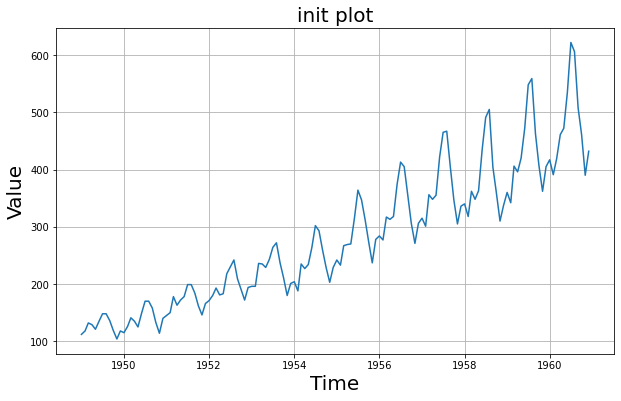

In [10]:
plot_time_series(df,'init plot')

Compute a rolling mean and a rolling std with an appropriate window size

In [15]:
df.rolling(12).mean()

,Passengers
Month,
1949-01-01,NaN
1949-02-01,NaN
1949-03-01,NaN
1949-04-01,NaN
1949-05-01,NaN
...,...
1960-08-01,463.333333
1960-09-01,467.083333
1960-10-01,471.583333


In [16]:
df.rolling(12).std()

,Passengers
Month,
1949-01-01,NaN
1949-02-01,NaN
1949-03-01,NaN
1949-04-01,NaN
1949-05-01,NaN
...,...
1960-08-01,83.630500
1960-09-01,84.617276
1960-10-01,82.541954


Plot two timeseries:
- with rolling mean 
- with rolling std

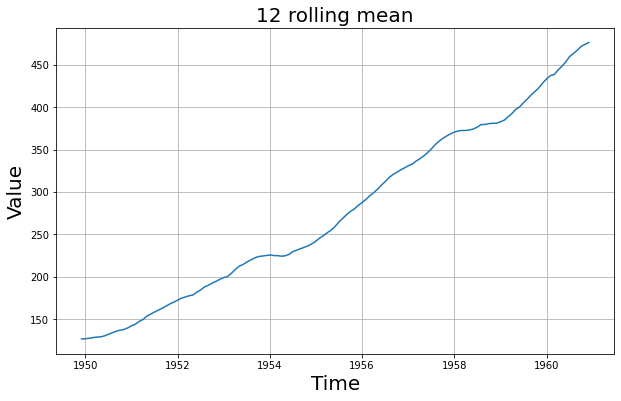

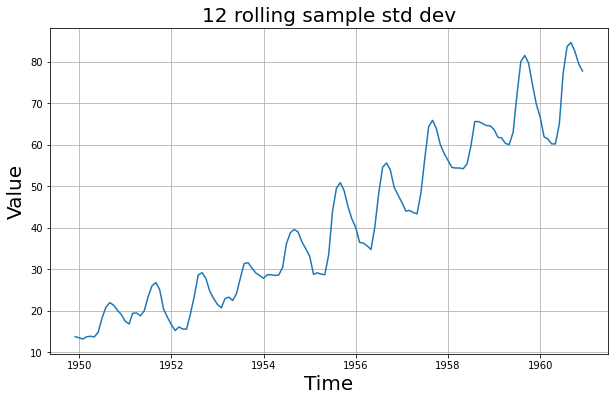

In [18]:
plot_time_series(df.rolling(12).mean(),'12 months rolling mean')
plot_time_series(df.rolling(12).std(),'12 months rolling sample std dev')

Test the stationarity of all timeseries

In [22]:
from statsmodels.tsa.stattools import adfuller
def ADF_Stationarity_Test(timeseries,significance_level=0.05):
    if isinstance(timeseries,np.ndarray):
        result = adfuller(timeseries)
    else:
        result = adfuller(timeseries.values)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if result[1] > significance_level :
        print(f'the data has a unit root and is non-stationary significance level:{significance_level}, p-value:{result[1]}')
    else:
        print(f'the data is stationary significance level:{significance_level}, p-value:{result[1]}')

In [26]:
ADF_Stationarity_Test(df)
print('\n')
ADF_Stationarity_Test(df.rolling(12).mean().dropna())
print('\n')
ADF_Stationarity_Test(df.rolling(12).std().dropna())

ADF Statistic: 0.815369
p-value: 0.991880
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579
the data has a unit root and is non-stationary significance level:0.05, p-value:0.9918802434376411


ADF Statistic: 0.873695
p-value: 0.992737
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579
the data has a unit root and is non-stationary significance level:0.05, p-value:0.9927372598211598


ADF Statistic: 1.286869
p-value: 0.996534
Critical Values:
	1%: -3.487
	5%: -2.886
	10%: -2.580
the data has a unit root and is non-stationary significance level:0.05, p-value:0.9965343927018503


Transform the original timeseries with logarithm

In [62]:
df['Passengers_log'] = np.log(df['Passengers'])
df['Passengers_log'] = df['Passengers_log'] - df['Passengers_log'].shift(6)

Plot transformed timeseries

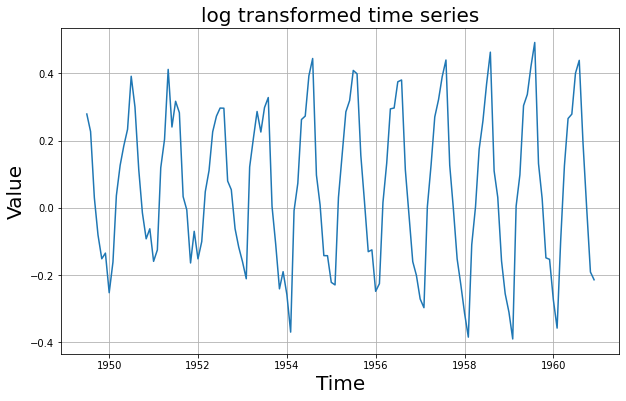

In [63]:
plot_time_series(df['Passengers_log'] ,'log transformed time series')

Test the stationarity of transformed timeseries. If it isn't stationary, try different transformation techniques

In [65]:
ADF_Stationarity_Test(df['Passengers_log'].dropna(),.5)

ADF Statistic: -3.265529
p-value: 0.016491
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579
the data is stationary significance level:0.5, p-value:0.016491446253817044


Use the stationary TS and find the optimal (p,d,q) params of ARIMA model

/home/henri/miniconda2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/henri/miniconda2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
                             ARIMA Model Results                              
Dep. Variable:       D.Passengers_log   No. Observations:                  137
Model:                 ARIMA(1, 1, 2)   Log Likelihood                  76.662
Method:                       css-mle   S.D. of innovations              0.138
Date:                Mon, 09 Nov 2020   AIC                           -143.324
Time:                        19:41:24   BIC                           -128.724
Sample:                    08-01-1949   HQIC                        

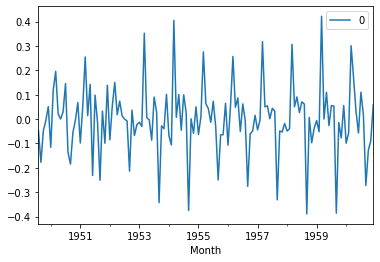

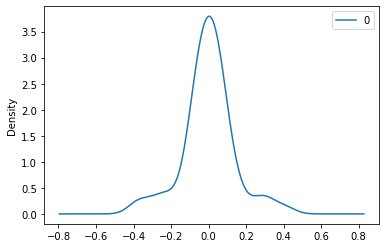

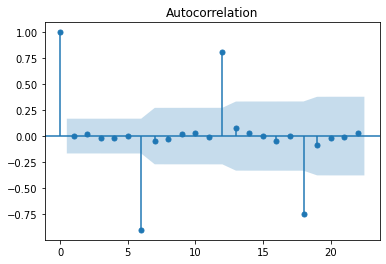

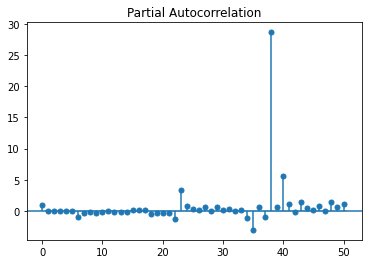

                0
count  137.000000
mean     0.000265
std      0.138729
min     -0.389294
25%     -0.056280
50%      0.000225
75%      0.055647
max      0.421913


In [70]:
# fit model
model = ARIMA(df['Passengers_log'].dropna(), order=(1,1,2))
model_fit = model.fit(disp=0)
print(model_fit.summary()) # This summarizes the coefficient values used as well as the skill of the fit on the on the in-sample observations.
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot() # First, we get a line plot of the residual errors, suggesting that there may still be some trend information not captured by the model.
plt.show()
residuals.plot(kind='kde') # Next, we get a density plot of the residual error values, suggesting the errors are Gaussian, but may not be centered on zero.
plt.show()
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals)
plt.show()
plot_pacf(residuals, lags=50)
plt.show()
print(residuals.describe())


Plot the predictions (not transformed to the original scale)

predicted=-0.222876, expected=-0.296777
predicted=-0.273327, expected=0.002813
predicted=0.084231, expected=0.128617
predicted=0.231350, expected=0.269999
predicted=0.337660, expected=0.321420
predicted=0.304353, expected=0.389465
predicted=0.332935, expected=0.439219
predicted=0.417397, expected=0.126484
predicted=0.039754, expected=-0.002878
predicted=-0.114536, expected=-0.151806
predicted=-0.230028, expected=-0.227894
predicted=-0.222146, expected=-0.313092
predicted=-0.263121, expected=-0.384278
predicted=-0.371004, expected=-0.109771
predicted=-0.029329, expected=0.002878
predicted=0.110241, expected=0.174091
predicted=0.259863, expected=0.258235
predicted=0.268876, expected=0.367499
predicted=0.331250, expected=0.462507
predicted=0.455349, expected=0.109771
predicted=0.008506, expected=0.031120
predicted=-0.097919, expected=-0.157831
predicted=-0.253762, expected=-0.255263
predicted=-0.262189, expected=-0.310340
predicted=-0.258190, expected=-0.389748
predicted=-0.368901, expect

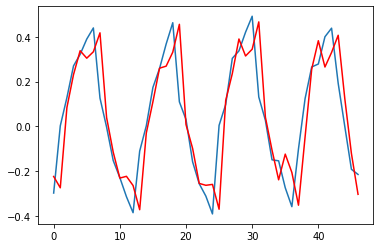

In [75]:
from sklearn.metrics import mean_squared_error
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
 

X = df['Passengers_log'].dropna().values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

Plot the predictions (transformed to the original scale)

Plot the predictions for the next 10 years